In [1]:
%matplotlib inline
import random
import subprocess
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option('display.max_rows', 15000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Evaluation of ITE

To confirm the effectiveness of the presented lightweight approach to constructive disjunction, we compare our ITE implementation to the corresponding standard methods contained in SICStus Prolog.

We start by defining a couple of helper functions and settings, especially for allowing Latex compatible plotting.

In [18]:
def figsize_column(scale, height_ratio=1.0):
    fig_width_pt = 180  # Get this from LaTeX using \the\columnwidth
    inches_per_pt = 1.0 / 72.27  # Convert pt to inch
    golden_mean = (np.sqrt(5.0) - 1.0) / 2.0  # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt * inches_per_pt * scale  # width in inches
    fig_height = fig_width * golden_mean * height_ratio  # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size


def figsize_text(scale, height_ratio=1.0):
    fig_width_pt = 361  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27  # Convert pt to inch
    golden_mean = (np.sqrt(5.0) - 1.0) / 2.0  # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt * inches_per_pt * scale  # width in inches
    fig_height = fig_width * golden_mean * height_ratio  # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size


pgf_with_latex = {  # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
    "text.usetex": True,  # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],  # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 9,
    "font.size": 9,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.figsize": figsize_column(1.0),
    "text.latex.preamble": [
        r"\usepackage[utf8x]{inputenc}",  # use utf8 fonts because your computer can handle it :)
        r"\usepackage[T1]{fontenc}",  # plots will be generated using this preamble
    ]
}

sns.set_style("white", pgf_with_latex)
sns.set_context("paper")
import matplotlib.pyplot as plt
import matplotlib

LABELS = {
    "cd/3_0.9": "cd/3 (*0.9)",
    "cd/3_1": "cd/3 (*1)",
    "cd/3_1.25": "cd/3 (*1.25)",
    "cd/3_1.5": "cd/3 (*1.5)",
    "cd/3_2": "cd/3 (*2)",
    "cd/3_3": "cd/3 (*3)",
    "cd/3_4": "cd/3 (*4)",
    "cd/3_5": "cd/3 (*5)",
    "native": "clp(FD)",
    "reg": "clp(FD)",
    "smt": "smt",
    "global": "Global",
    "nb_clauses": "Number of Clauses",
    "time": "Propagation Time",
    "mum": "Ultrametric",
    "elemctr": "Element",
    "disjctr": "Disjunctive",
    "lexctr": "Lex",
    "domctr": "Domain"
}

## Constraints

Replace `constraints.csv` with the file containing the output from running `constraints.exe`.

In [3]:
df = pd.read_csv('constraints.csv', sep=';')
df.head()

,benchmark,n,op,result,time,resumptions,entailments,prunings,backtracks,constraints,memory
0,domctr2,100,cd(2),9,28,425312,443,160,2175,11,64
1,domctr2,100,cd(3),9,4,281296,559,202,2837,12,76
2,domctr2,100,cd,9,17,1019712,15627,5296,17345,18,302
3,domctr2,100,reg,9,67,13367040,50246,40229,30640,8,20302
4,domctr2,100,smt,9,1695,4149056,34,4,236,8,2


In [4]:
benchmarks = df.benchmark.unique()
benchmarks

array(['domctr2', 'elemctr2', 'lexctr2', 'mulctr2'], dtype=object)

In [ ]:
df[(df.result != 'timeout')].replace(LABELS)

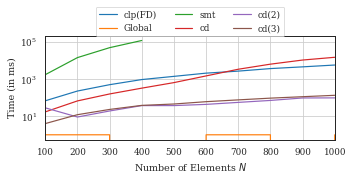

In [79]:
bdf = df[(df.benchmark == 'domctr2') & (df.result != 'timeout')].replace(LABELS)
bdf['n'] = bdf['n'].astype(int)
#bdf['time'] = bdf['time'] / 1000

fig, ax = plt.subplots(figsize=figsize_text(1.0, height_ratio=0.9))
sns.lineplot(x='n', y='time', hue='op', hue_order=['clp(FD)', 'Global', 'smt', 'cd', 'cd(2)', 'cd(3)'], data=bdf, ax=ax)
ax.set_yscale('log')
ax.set_xlim([bdf['n'].min(), bdf['n'].max()])
handles, labels = ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(0.5, 1.28), loc=9, borderaxespad=0., 
          handles=handles[1:], labels=labels[1:], ncol=3)
#ax.set_xticks(bdf['n'].unique())
ax.set_xlabel('Number of Elements $N$')
ax.set_ylabel('Time (in ms)')
ax.grid()
fig.tight_layout()
fig.savefig('domctr.pgf', dpi=500, bbox_inches='tight')
#fig.show()

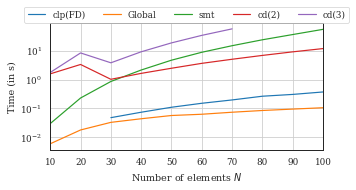

In [82]:
bdf = df[(df.benchmark == 'lexctr2') & (df.result != 'timeout')].replace(LABELS)
bdf['n'] = bdf['n'].astype(int)
#bdf.loc[bdf.time >= 60000, 'time'] = 0
bdf['time'] = bdf['time'] / 1000
#bdf.loc[(bdf.result == 'timeout') & (bdf.n == bdf.n.min()), 'time'] = 0.0
#bdf = bdf[~((bdf.result == 'timeout') & (bdf.n > bdf.n.min()))]

fig, ax = plt.subplots(figsize=figsize_text(1.0, height_ratio=0.9))
sns.lineplot(x='n', y='time', hue='op', hue_order=['clp(FD)', 'Global', 'smt', 'cd(2)', 'cd(3)'], data=bdf, ax=ax)
ax.set_yscale('log')
#ax.set_ylim([0, 60])
ax.set_xlim([bdf['n'].min(), bdf['n'].max()])
handles, labels = ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(0.5, 1.13), loc=9, borderaxespad=0., 
          handles=handles[1:], labels=labels[1:], ncol=5)
#ax.set_xticks([10, 50, 100, 150, 200, 250, 300, 350, 400, 450])
ax.set_xlabel('Number of elements $N$')
ax.set_ylabel('Time (in s)')
ax.grid()
fig.tight_layout()
fig.savefig('lexctr.pgf', dpi=500, bbox_inches='tight')

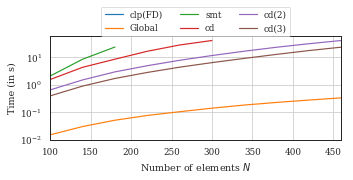

In [84]:
bdf = df[(df.benchmark == 'elemctr2')].replace(LABELS)
bdf['n'] = bdf['n'].astype(int)
#bdf.loc[bdf.time >= 60000, 'time'] = 0
bdf['time'] = bdf['time'] / 1000
bdf.loc[(bdf.result == 'timeout') & (bdf.n == bdf.n.min()), 'time'] = 0.0
bdf = bdf[~((bdf.result == 'timeout') & (bdf.n > bdf.n.min()))]

fig, ax = plt.subplots(figsize=figsize_text(1.0, height_ratio=0.9))
sns.lineplot(x='n', y='time', hue='op', hue_order=['clp(FD)', 'Global', 'smt', 'cd', 'cd(2)', 'cd(3)'], data=bdf, ax=ax)
ax.set_yscale('log')
#ax.set_ylim([0, 60])
ax.set_xlim([bdf['n'].min(), bdf['n'].max()])
handles, labels = ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(0.5, 1.28), loc=9, borderaxespad=0., 
          handles=handles[1:], labels=labels[1:], ncol=3)
#ax.set_xticks([10, 50, 100, 150, 200, 250, 300, 350, 400, 450])
ax.set_xlabel('Number of elements $N$')
ax.set_ylabel('Time (in s)')
ax.grid()
fig.tight_layout()
fig.savefig('elemctr.pgf', dpi=500, bbox_inches='tight')

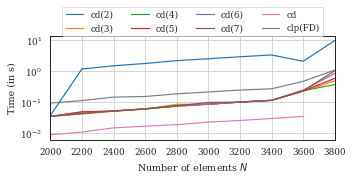

In [85]:
bdf = df[(df.benchmark == 'mulctr2') & (df.result != 'timeout')].replace(LABELS)
bdf['n'] = bdf['n'].astype(int)
#bdf.loc[bdf.time >= 60000, 'time'] = 0
bdf['time'] = bdf['time'] / 1000

fig, ax = plt.subplots(figsize=figsize_text(1.0, height_ratio=0.9))
sns.lineplot(x='n', y='time', hue='op', data=bdf, ax=ax)
ax.set_yscale('log')
ax.set_xlim([bdf['n'].min(), bdf['n'].max()])
handles, labels = ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(0.5, 1.28), loc=9, borderaxespad=0., 
          handles=handles[1:], labels=labels[1:], ncol=4)
#ax.set_xticks([10, 50, 100, 150, 200, 250, 300, 350, 400, 450])
ax.set_xlabel('Number of elements $N$')
ax.set_ylabel('Time (in s)')
ax.grid()
fig.tight_layout()
fig.savefig('mulctr.pgf', dpi=500, bbox_inches='tight')